<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/marcoteran/deeplearning/blob/master/notebooks/3.4_deeplearning_dataaugmentationandtransferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Abrir en Colab" title="Abrir y ejecutar en Google Colaboratory"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/marcoteran/deeplearning/blob/master/notebooks/3.4_deeplearning_dataaugmentationandtransferlearning.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Abrir en Kaggle" title="Abrir y ejecutar en Kaggle"/></a>
  </td>
</table>

### Ejemplo de cÃ³digo
# SesiÃ³n 12: Series de tiempo
## Deep Learning y series de tiempo

*Name:* Marco Teran
*E-mail:* marco.tulio.teran@gmail.com,
[Website](http://marcoteran.github.io/),
[Github](https://github.com/marcoteran),
[LinkedIn](https://www.linkedin.com/in/marcoteran/).

## Create and predict synthetic data with time series decomposition

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.10.1


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

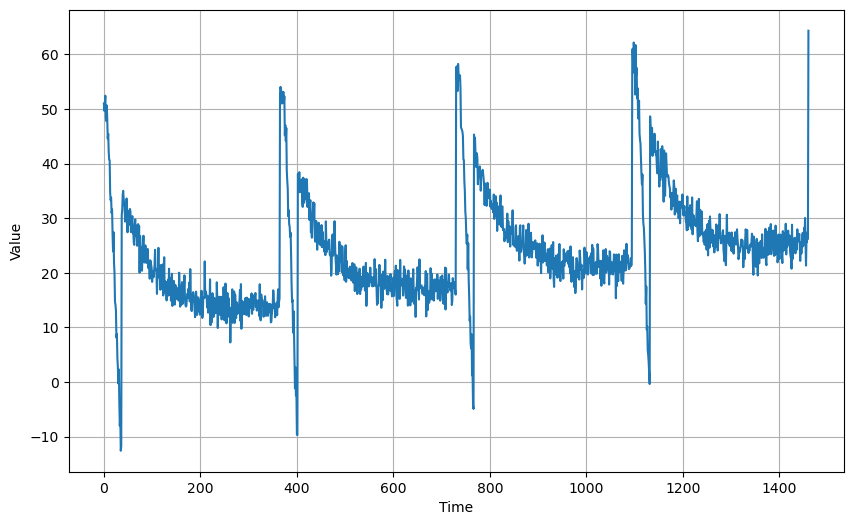

In [3]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.01
noise_level = 2

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# EXPECTED OUTPUT
# Chart as in the screencast. First should have 5 distinctive 'peaks'

Now that we have the time series, let's split it so we can start forecasting

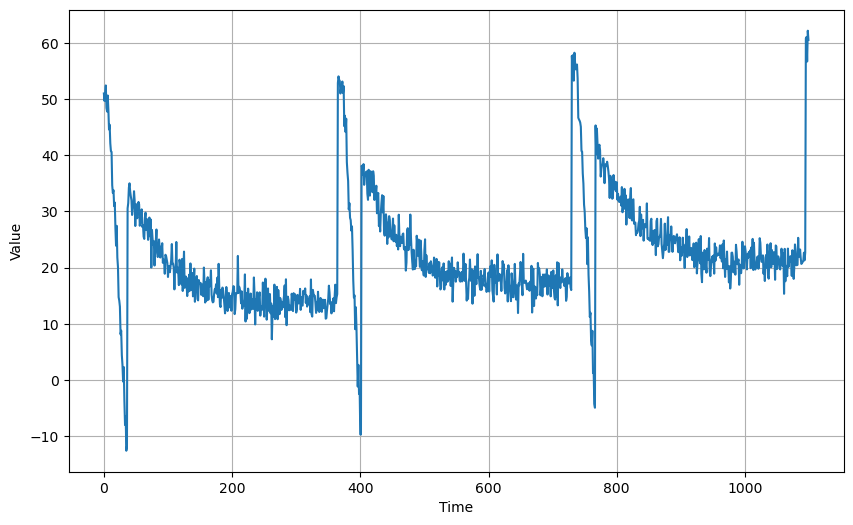

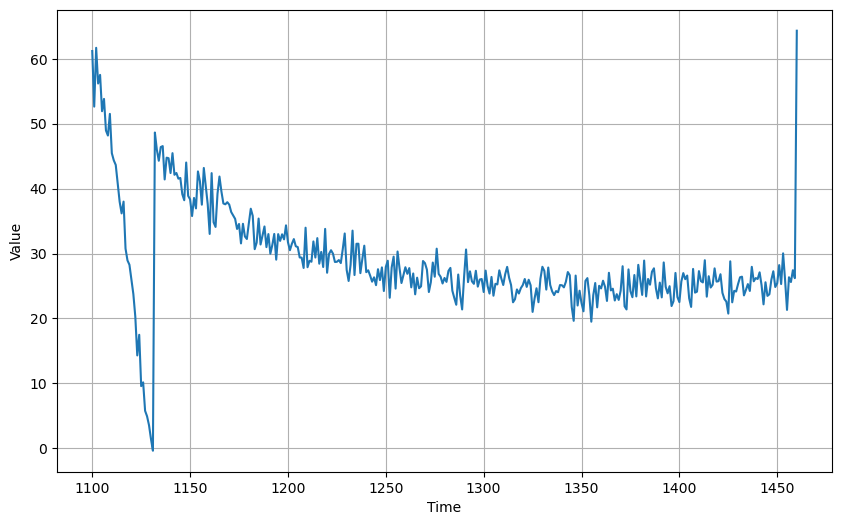

In [4]:
split_time = 1100
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

# EXPECTED OUTPUT
# Chart WITH 4 PEAKS between 50 and 65 and 3 troughs between -12 and 0
# Chart with 2 Peaks, first at slightly above 60, last at a little more than that, should also have a single trough at about 0

# Naive Forecast

In [5]:
naive_forecast = series[split_time - 1:-1]

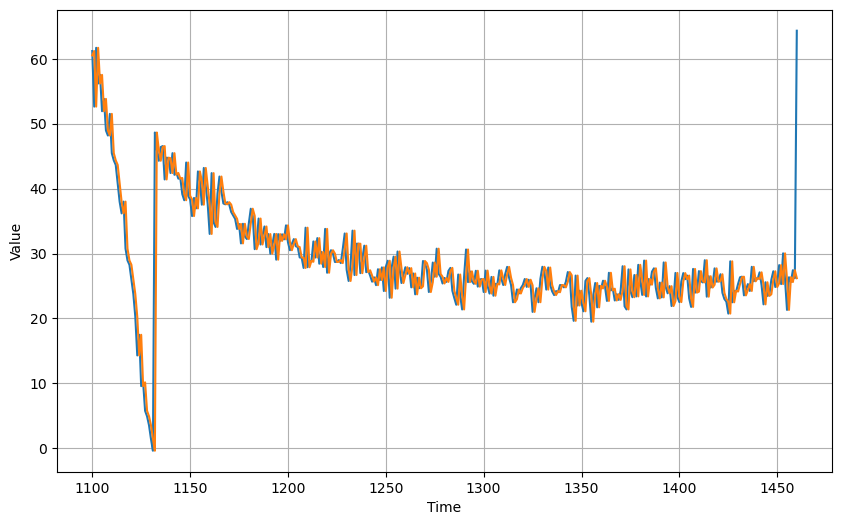

In [6]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

# Expected output: Chart similar to above, but with forecast overlay

Let's zoom in on the start of the validation period:

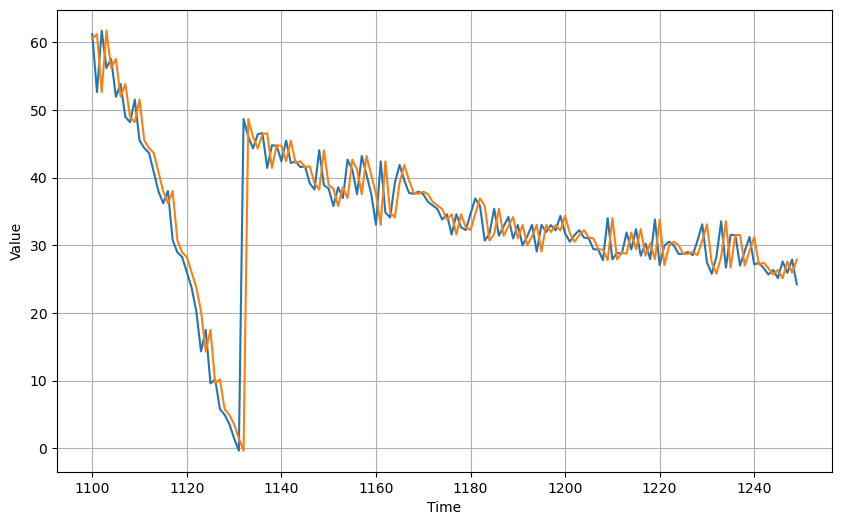

In [7]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=0, end=150)

# EXPECTED - Chart with X-Axis from 1100-1250 and Y Axes with series value and projections. Projections should be time stepped 1 unit 'after' series

Now let's compute the mean squared error and the mean absolute error between the forecasts and the predictions in the validation period:

In [8]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())
# Expected Output
# 19.578304
# 2.6011968

19.578308
2.6011975


That's our baseline, now let's try a moving average:

In [9]:
def moving_average_forecast(series, window_size):
    """
    Forecasts the mean of the last few values.
    If window_size=1, then this is equivalent to naive forecast
    """
    forecast = []

    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

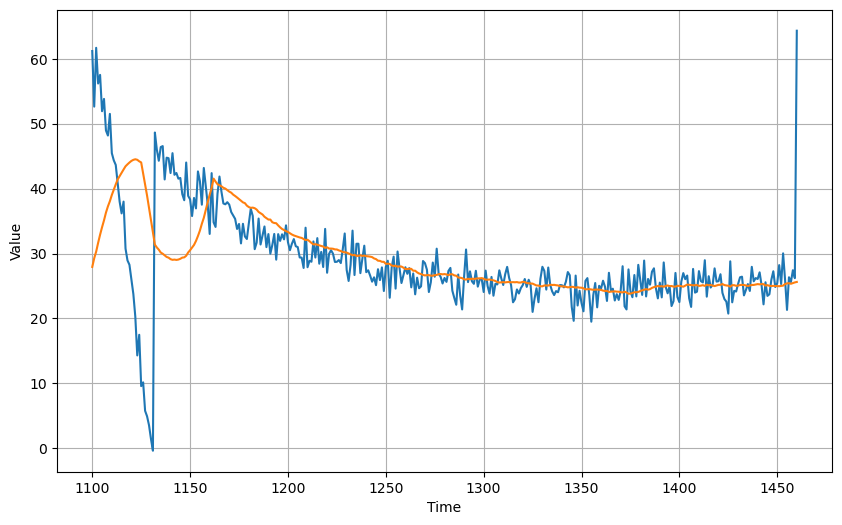

In [10]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)
    
# EXPECTED OUTPUT
# CHart with time series from 1100->1450+ on X
# Time series plotted
# Moving average plotted over it

In [11]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())
# EXPECTED OUTPUT
# 65.786224
# 4.3040023

65.786224
4.3040023


That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will subtract the value at time *t* â€“ 365 from the value at time *t*.

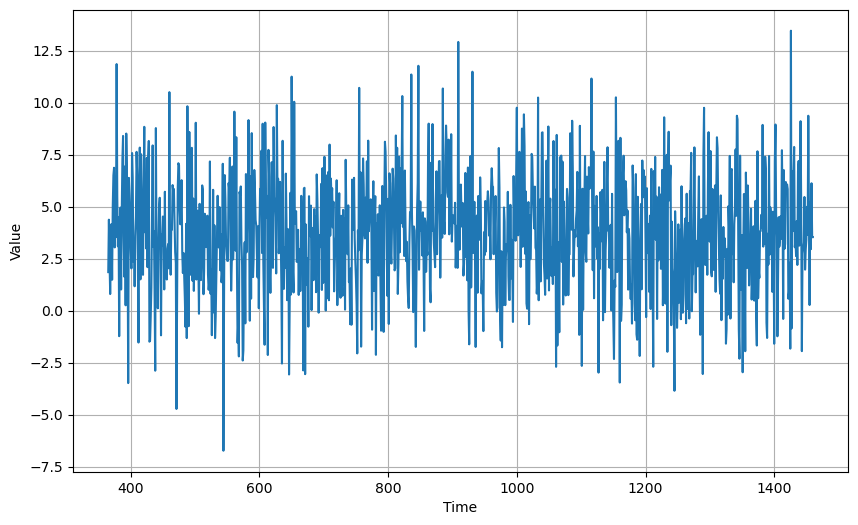

In [12]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()
    
# EXPECETED OUTPUT: CHart with diffs

Great, the trend and seasonality seem to be gone, so now we can use the moving average:

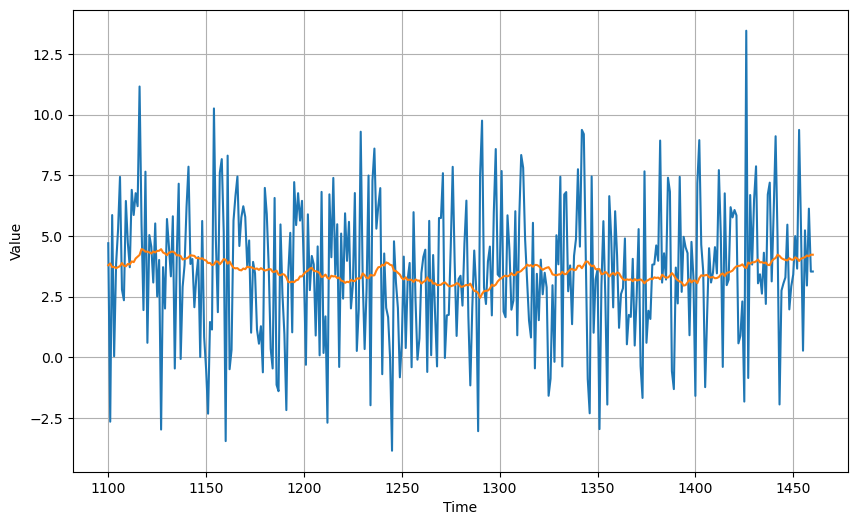

In [13]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()
            
# Expected output. Diff chart from 1100->1450 +
# Overlaid with moving average

Now let's bring back the trend and seasonality by adding the past values from t â€“ 365:

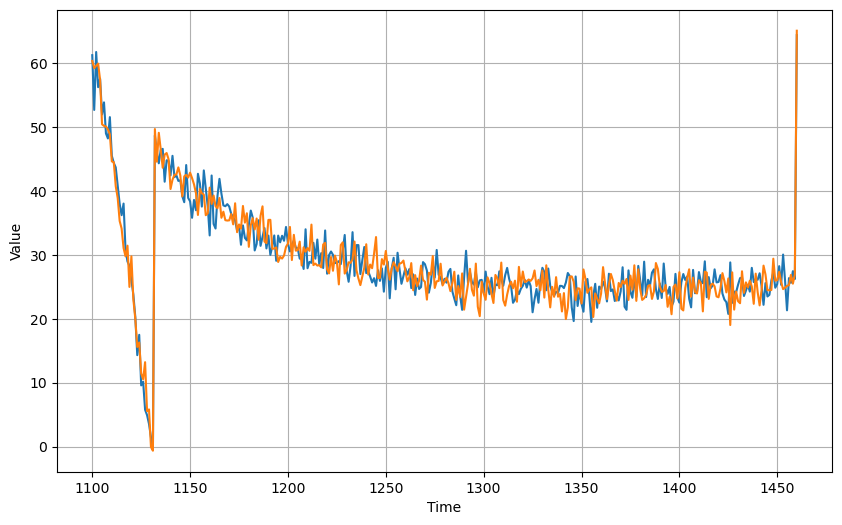

In [14]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()
# Expected output: Chart from 1100->1450+ on X. Same chart as earlier for time series, but projection overlaid looks close in value to it

In [15]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())
# EXPECTED OUTPUT
# 8.498155
# 2.327179

8.498155
2.3271792


Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:

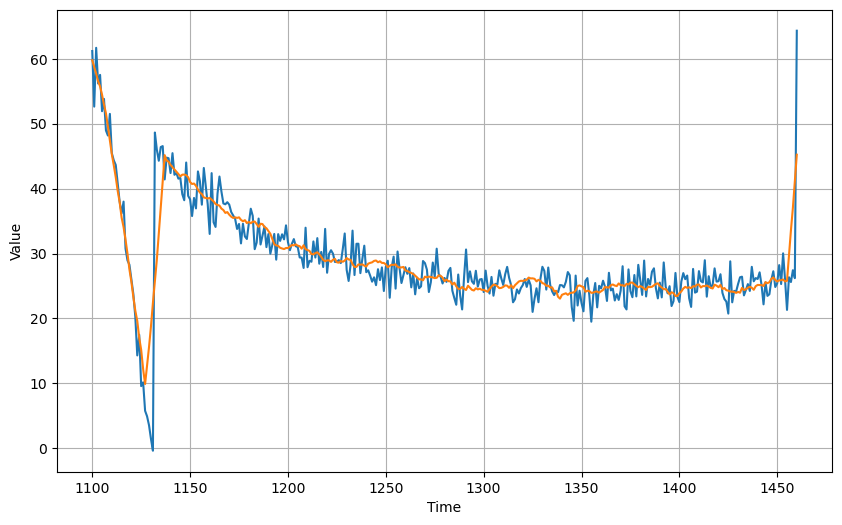

In [16]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()
            
# EXPECTED OUTPUT:
# Similar chart to above, but the overlaid projections are much smoother

In [17]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

12.527958
2.2034435


___

## Prepare features and labels

In [18]:
dataset = tf.data.Dataset.range(10)
for val in dataset:
    print(val.numpy())

0
1
2
3
4
5
6
7
8
9


In [19]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
        print()

0 
1 
2 
3 
4 
1 
2 
3 
4 
5 
2 
3 
4 
5 
6 
3 
4 
5 
6 
7 
4 
5 
6 
7 
8 
5 
6 
7 
8 
9 
6 
7 
8 
9 
7 
8 
9 
8 
9 
9 


In [20]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
        print()

0 
1 
2 
3 
4 
1 
2 
3 
4 
5 
2 
3 
4 
5 
6 
3 
4 
5 
6 
7 
4 
5 
6 
7 
8 
5 
6 
7 
8 
9 


In [21]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
    print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [22]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x,y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [23]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
for x,y in dataset:
    print(x.numpy(), y.numpy())


[1 2 3 4] [5]
[2 3 4 5] [6]
[5 6 7 8] [9]
[4 5 6 7] [8]
[0 1 2 3] [4]
[3 4 5 6] [7]


In [24]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())

x =  [[3 4 5 6]
 [1 2 3 4]]
y =  [[7]
 [5]]
x =  [[4 5 6 7]
 [5 6 7 8]]
y =  [[8]
 [9]]
x =  [[0 1 2 3]
 [2 3 4 5]]
y =  [[4]
 [6]]


___

## Predict synthetic data with Linear Regression

In [25]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [26]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [27]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


C:\Users\marco\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Layer weights [array([[-0.03078044],
       [ 0.04557154],
       [-0.00625421],
       [ 0.01734269],
       [-0.00158633],
       [ 0.03927691],
       [ 0.00696505],
       [-0.02618608],
       [-0.05540337],
       [ 0.09428998],
       [-0.01899896],
       [-0.00494051],
       [-0.06978175],
       [ 0.09263147],
       [-0.05754757],
       [ 0.10447933],
       [ 0.05789641],
       [ 0.11656086],
       [ 0.26513743],
       [ 0.44566202]], dtype=float32), array([0.01462031], dtype=float32)]


In [28]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


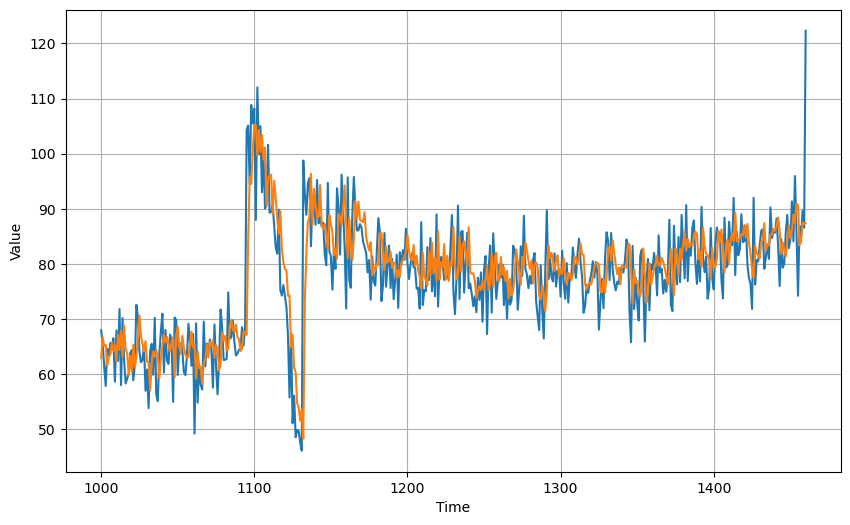

In [29]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [30]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.30103

___

## Predict synthetic data with MLP

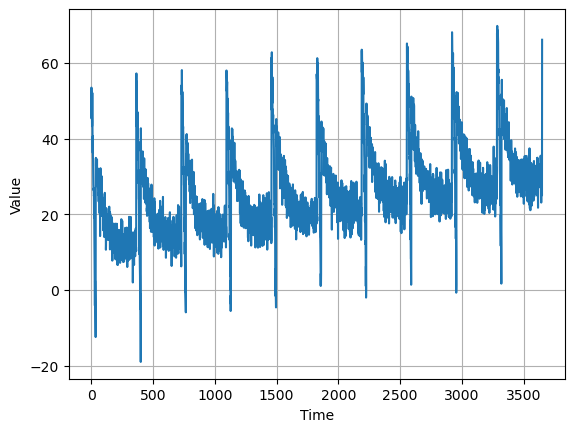

In [31]:
time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [32]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer='adam')
model.fit(dataset,epochs=100,verbose=0)

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


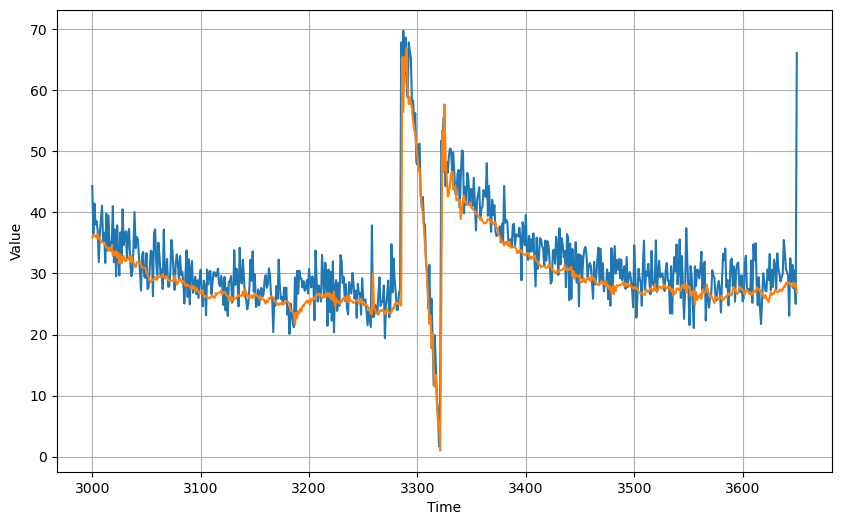

In [33]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [34]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

3.2006779

___

## Finding an optimal learning rate for a RNN

In [35]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

## Let's try training a simple 2 layers RNN with different learning rates.

In [36]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 72ms/step - loss: 185.0846 - mae: 185.5846 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 1s 66ms/step - loss: 184.7613 - mae: 185.2613 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 1s 67ms/step - loss: 184.2469 - mae: 184.7469 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 1s 67ms/step - loss: 183.6078 - mae: 184.1078 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 1s 69ms/step - loss: 182.8667 - mae: 183.3667 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 1s 67ms/step - loss: 182.0305 - mae: 182.5305 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 1s 67ms/step - loss: 181.0957 - mae: 181.5957 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 1s 68ms/step - loss: 180.0558 - mae: 180.5558 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 1s 68ms/step - loss: 178.9014 - mae: 

(1e-08, 0.0001, 0.0, 30.0)

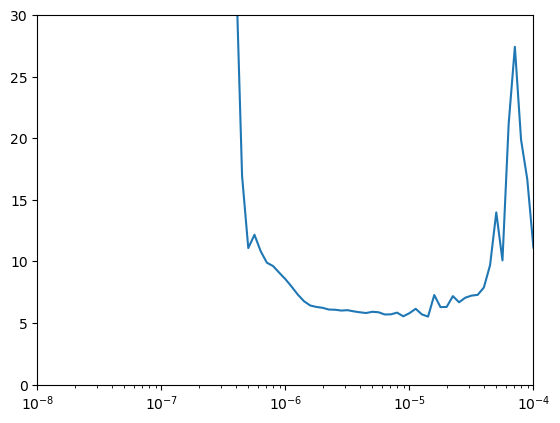

In [37]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

## 5*10e-5 seems to be a reasonable learning rate, hence it gets chosen.

In [38]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 2s 69ms/step - loss: 58.2924 - mae: 58.7922
Epoch 2/400
8/8 [==============================] - 1s 66ms/step - loss: 21.7763 - mae: 22.2718
Epoch 3/400
8/8 [==============================] - 1s 67ms/step - loss: 16.5101 - mae: 17.0052
Epoch 4/400
8/8 [==============================] - 1s 69ms/step - loss: 15.5549 - mae: 16.0479
Epoch 5/400
8/8 [==============================] - 1s 67ms/step - loss: 13.6594 - mae: 14.1529
Epoch 6/400
8/8 [==============================] - 1s 69ms/step - loss: 12.2557 - mae: 12.7497
Epoch 7/400
8/8 [==============================] - 1s 69ms/step - loss: 10.2460 - mae: 10.7364
Epoch 8/400
8/8 [==============================] - 1s 69ms/step - loss: 8.3164 - mae: 8.8053
Epoch 9/400
8/8 [==============================] - 1s 70ms/step - loss: 14.3843 - mae: 14.8754
Epoch 10/400
8/8 [==============================] - 1s 68ms/step - loss: 19.1919 - mae: 19.6873
Epoch 11/400
8/8 [==============================] -

8/8 [==============================] - 1s 67ms/step - loss: 5.4471 - mae: 5.9259
Epoch 174/400
8/8 [==============================] - 1s 68ms/step - loss: 4.8803 - mae: 5.3597
Epoch 175/400
8/8 [==============================] - 1s 69ms/step - loss: 5.0379 - mae: 5.5177
Epoch 176/400
8/8 [==============================] - 1s 68ms/step - loss: 5.1801 - mae: 5.6611
Epoch 177/400
8/8 [==============================] - 1s 68ms/step - loss: 6.1197 - mae: 6.6046
Epoch 178/400
8/8 [==============================] - 1s 69ms/step - loss: 7.8449 - mae: 8.3347
Epoch 179/400
8/8 [==============================] - 1s 69ms/step - loss: 5.1468 - mae: 5.6266
Epoch 180/400
8/8 [==============================] - 1s 71ms/step - loss: 4.8908 - mae: 5.3698
Epoch 181/400
8/8 [==============================] - 1s 68ms/step - loss: 4.8580 - mae: 5.3369
Epoch 182/400
8/8 [==============================] - 1s 68ms/step - loss: 4.5000 - mae: 4.9753
Epoch 183/400
8/8 [==============================] - 1s 67ms/ste

8/8 [==============================] - 1s 69ms/step - loss: 5.0826 - mae: 5.5629
Epoch 346/400
8/8 [==============================] - 1s 69ms/step - loss: 4.5432 - mae: 5.0229
Epoch 347/400
8/8 [==============================] - 1s 67ms/step - loss: 4.9846 - mae: 5.4620
Epoch 348/400
8/8 [==============================] - 1s 71ms/step - loss: 5.7766 - mae: 6.2597
Epoch 349/400
8/8 [==============================] - 1s 70ms/step - loss: 4.9952 - mae: 5.4724
Epoch 350/400
8/8 [==============================] - 1s 69ms/step - loss: 4.6195 - mae: 5.0960
Epoch 351/400
8/8 [==============================] - 1s 71ms/step - loss: 4.7678 - mae: 5.2488
Epoch 352/400
8/8 [==============================] - 1s 70ms/step - loss: 4.5832 - mae: 5.0587
Epoch 353/400
8/8 [==============================] - 1s 68ms/step - loss: 4.2488 - mae: 4.7266
Epoch 354/400
8/8 [==============================] - 1s 69ms/step - loss: 4.4858 - mae: 4.9599
Epoch 355/400
8/8 [==============================] - 1s 68ms/ste

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


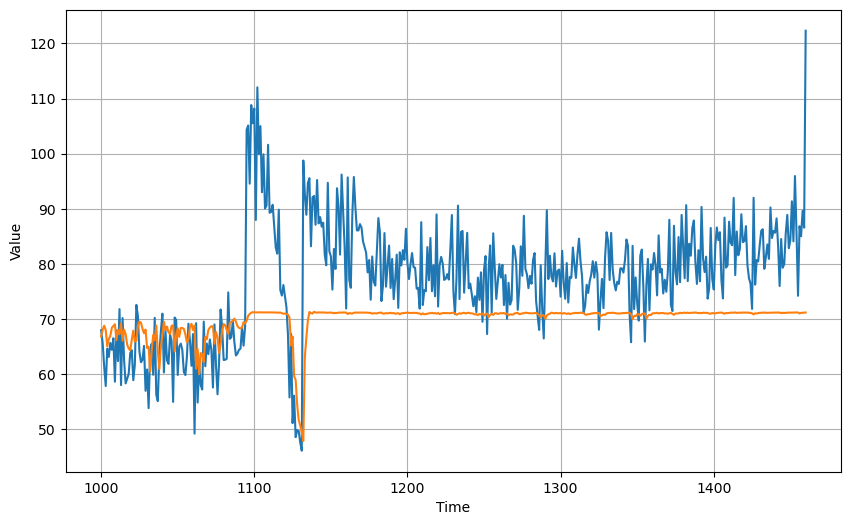

In [39]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [40]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

9.415889

<Figure size 640x480 with 0 Axes>

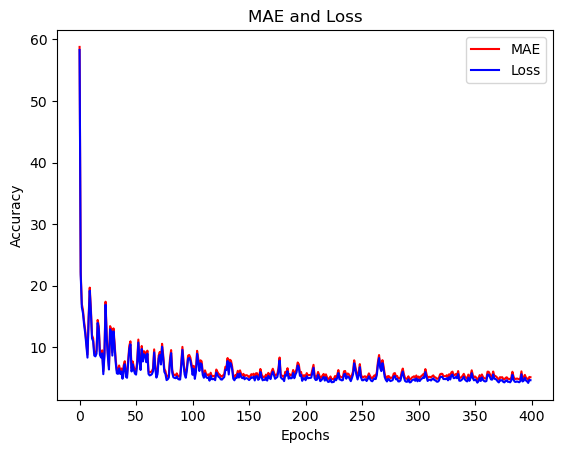

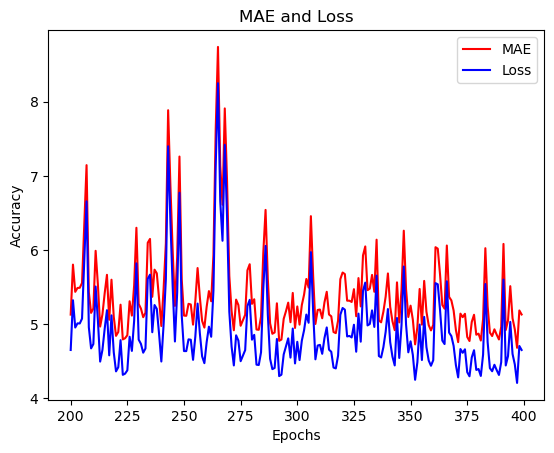

<Figure size 640x480 with 0 Axes>

In [41]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

# Seems to work fine!

___

## LSTM

In [42]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [43]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 6s 19ms/step - loss: 27.6807 - mae: 28.1749 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 13ms/step - loss: 11.7467 - mae: 12.2348 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 11.7299 - mae: 12.2186 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 11ms/step - loss: 11.6484 - mae: 12.1366 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 11ms/step - loss: 11.5777 - mae: 12.0659 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 11ms/step - loss: 11.5056 - mae: 11.9948 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 11ms/step - loss: 11.4365 - mae: 11.9259 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 11ms/step - loss: 11.3604 - mae: 11.8497 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 11ms/step - loss: 11.2719 - mae:

(1e-08, 0.0001, 0.0, 30.0)

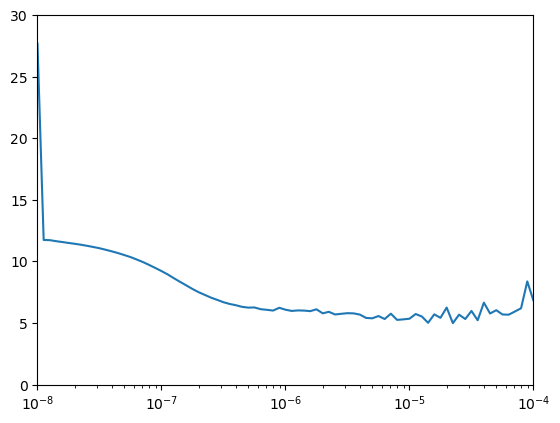

In [44]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [45]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=0)

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


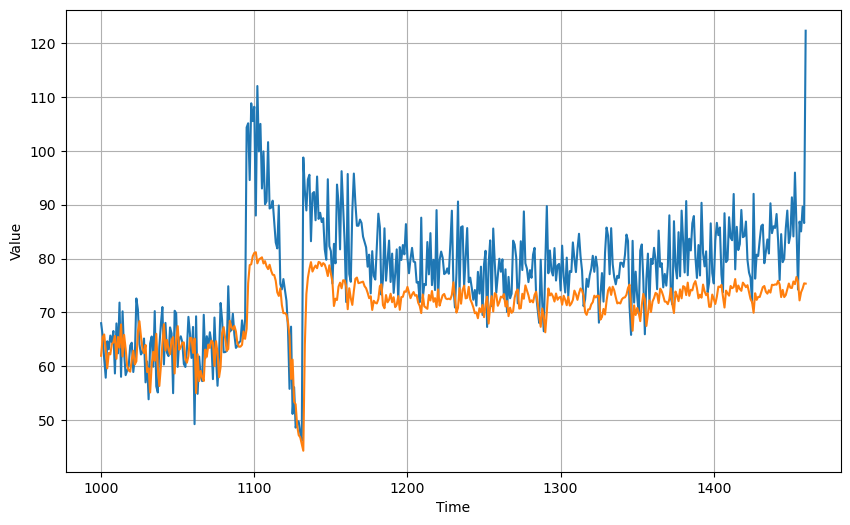

In [46]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [47]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

7.644993

<Figure size 640x480 with 0 Axes>

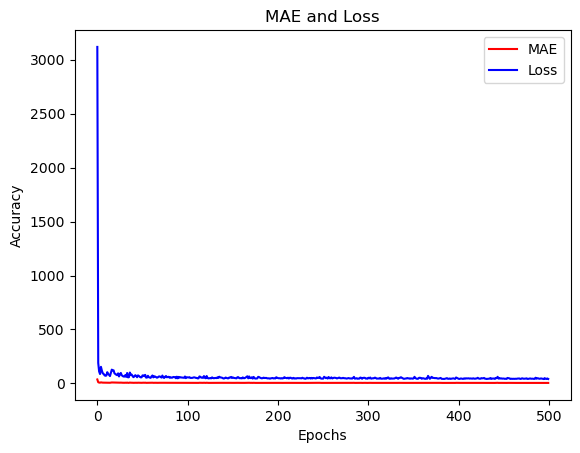

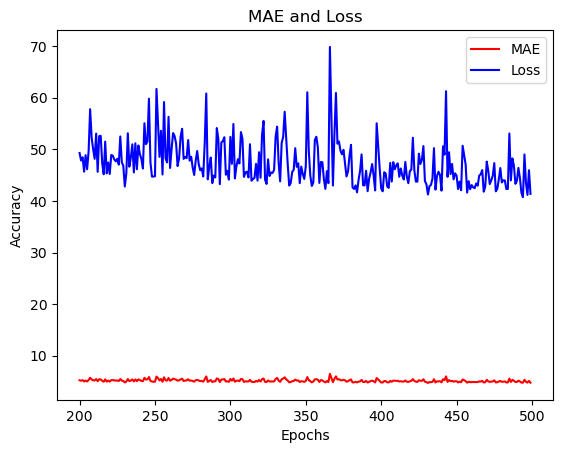

<Figure size 640x480 with 0 Axes>

In [48]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [49]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100, verbose=0)

In [51]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 6s 26ms/step - loss: 277.9865
Epoch 2/100
31/31 [==============================] - 1s 14ms/step - loss: 87.4893
Epoch 3/100
31/31 [==============================] - 1s 15ms/step - loss: 78.4523
Epoch 4/100
31/31 [==============================] - 1s 14ms/step - loss: 72.1872
Epoch 5/100
31/31 [==============================] - 1s 16ms/step - loss: 69.2303
Epoch 6/100
31/31 [==============================] - 1s 14ms/step - loss: 70.4181
Epoch 7/100
31/31 [==============================] - 1s 14ms/step - loss: 67.9047
Epoch 8/100
31/31 [==============================] - 1s 15ms/step - loss: 69.0096
Epoch 9/100
31/31 [==============================] - 1s 15ms/step - loss: 64.2865
Epoch 10/100
31/31 [==============================] - 1s 15ms/step - loss: 63.7371
Epoch 11/100
31/31 [==============================] - 0s 14ms/step - loss: 64.0332
Epoch 12/100
31/31 [==============================] - 1s 14ms/step - loss: 61.8488
Epoch 13/100

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


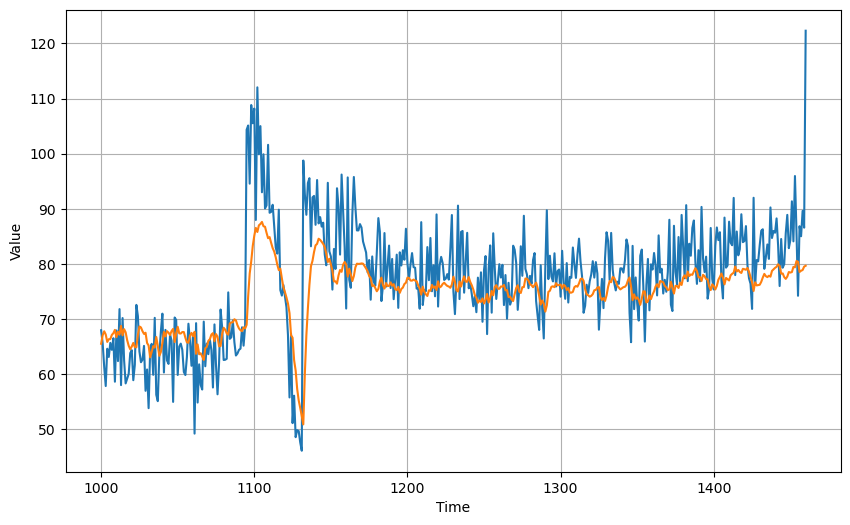

In [52]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [53]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.773885

<Figure size 640x480 with 0 Axes>

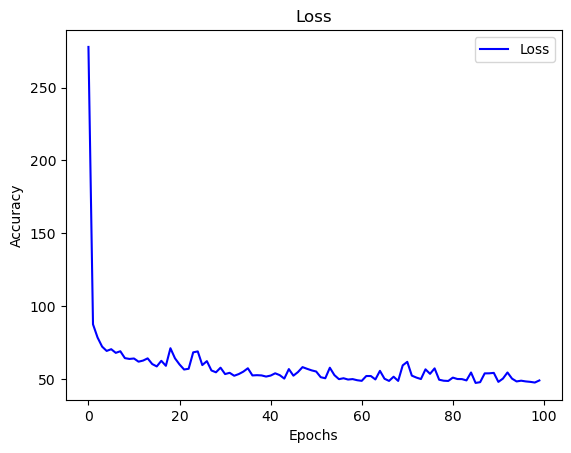

<Figure size 640x480 with 0 Axes>

In [59]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, loss, 'b')
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Loss"])

plt.figure()

___
Â¡Todo bien! Â¡Es todo por hoy! ðŸ˜€